OSE Scientific Computing | Winter 2021, M.Sc. in Economics, University of Bonn | [Sona Verdiyeva](https://github.com/s6soverd) and [Abraham Raju](https://github.com/Abraham-newbie)

# Prediction of Crime Rates using Brightness derived from Nighttime Satellite Light Images - VIIRS

This notebook contains derivation of brightness index from [VIIRS Nighttime Satellite Light Images](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG), and with the addition of other control variables, the prediction of crime rates in the city of Portland, Oregano state in US. As far as the brightness index concerns, the index is derived for all the neighborhoods in the city of Portland, for which the 'offense type and occurrence' datasets are available. Prediction of 

### Table of Contents 
* [1.Overview](#overview) 
* [2.VIIRS - Nighttime Satellite Light Images](#viirs) 
* [3.On the derivation of Brightness Index](#derivation) 
    * [3.1. Example: Manual Derivation](#manuald)
    * [3.2. Unit Test on Brightness Index function](#unittest)
* [4. Preparation of the data for further analysis](#datawrangling)
* [5. Interactive Mapping: Crime Data and Brightness Values across Years](#mapping)
* [6. Random Forest Regression: Prediction of crime rate using Brightness Index](#rfc)
* [7.Conclusion](#conclusion)
* [8.References](#references)


In [47]:
#### All the neccessary Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import IFrame, Image
import datetime as dt
#import geemap, ee
#try:
        #ee.Initialize()
#except Exception as e:
        #ee.Authenticate()
        #ee.Initialize()

# ! pip install openpyxl
#import geopandas
#import fiona
#import folium 
#import os
#from geopandas import GeoDataFrame


### Functions imported from the auxiliary file
import auxiliary.data_wrangling as dw
#import auxiliary.brightness as br
#import auxiliary.geo_converter as gc
#import auxiliary.maps as maps

## 1. Overview <a class="anchor" id="overview"></a>

## 2. VIIRS - Nighttime Satellite Light Images <a class="anchor" id="viirs"></a>

The first digital archive of nighttime lights taken by satellites established at the National Geophysical Data Center in 1992 contains nighttime data from two satelitte platforms - United States Air Force series of polar-orbiting Defense Meteorological Satellite Program-Operational Linescan System (DMSP-OLS) and the current NASA/NOAA SNPP satellite’s the Visible Infrared Imaging Radiometer Suite (VIIRS-DNB) (Xi Chen et al., 2019).  <br>
The first low-light imagery from DMSP dates back to 1960's, while the dataset availability for VIIRS-DNB covers the period from 2014-01-01 onwards. Some new features of VIIRS lights data have eliminated or reduced the limitations of DMSP-OLS sensor. In a nutshell, the main limitations of DMSP-OLS sensor are the following (Feng-Chi Hsu et al., 2015):
* Low radiometric resolution
* No on-board calibration
* Large spatial resolution
* Saturation in urban cores <br>

To process the satellite imagery, we will be using **Google Earth Engine (GEE)**, which is a cloud-based platform for planetary-scale geospatial analysis. It is open and free to the public. In addition, GEE provides access to multiple remotel-sensed datasets, including VIIRS-DNB. To pull VIIRS-DNB nighttime light images from GEE, the eath engine snippet [ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) is used. <br>
For interactive mapping with GEE, **geemap** -a python package - is used, as it is not part of the standard Python library, it should be seperately downloaded and installed. Geemap can be used to analyse and visualize datasets available in GEE. <br>
To work with satellite data that covers enormous area geospatially, one can work with smaller Area of Interest, that can be either a buffer zone around a latitude-longitude point or a geometry from geopolitical boundary; and then the entire image dataset is clipped into this smaller AOI. <br>
If one wants to focus on the geopolitical boundary of a country, then a **shapefile** of the country is used. Shapefile  is a digital vector storage format for storing the geographic location. Geographic features in a shapefile can be represented by points, lines, or polygons (areas).  <br>
To import shapefile with geemap, the **Coordinate Reference System (CRS)** of the shapefile should be EPSG:4326. CRS basically tells Python how the coordinates inside a shapefile relates to places on Earth. 

## 3.On the derivation of Brightness Index <a class="anchor" id="derivation"></a>

The function below is generic enough to work with VIIRS-DNB image collection for any time period available and for any AOI (either buffer zone or shapefile). The daily images in VIIRS-DNB are aggregated into **monthly composites**, so given a point on Earth and a year, there are only 12 images in the collection. 

Since we are going to work with shapefile of the city, we need to provide the path to the shapefile, rather than the shapefile itself. Because to import the shapefile with geemap, a path to your shapefile should be given. And the directory in which your .shp (shapefile) is located should also include .dbf, .cpg, .prj, .shx extension files that comes with a usual shapefile folder. <br>
To read the content of the shapefile, **geemap** package is being used, which only accepts the shapefile with the CRS format being equal to ***"EPSG:4326"***.  The brightness.py file inside auxiliary comes with a function to identify the crs of the shapefile. Unless the CRS of a shapefile is equal to ***"EPSG:4326"***, the brightness function will set the CRS to the accepted format. <br>
To get to know how to use the brightness function and access the explanation of the arguments used, one can use the function below to access the docstrings:

In [2]:
def explanation(function):
    return print(function.__doc__)
#explanation(function = br.brightness)

**Step 1:** <br>
Extracting the image collection for the years specified and the given band from the VIIRS-DNB Nighttime satellite light images, we use **ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(date_from, date_to).select(band)** Earth Engine snippet. VIIRS Image Collection is available overall for the years: 2014-01-01 - 2021-05-01. **NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG** is simply the complete dataset. For the Dataset - VIIRS Stray-light Corrected Day/Night Band composites, there are two bands available: 
* avg_rad(=Average DNB radiance values.) 
* cf_cvg (=Cloud-free coverages, This band can be used to identify areas with low numbers of observations 
     where the quality is reduced.) 

**Step 2:** <br>
First we need to create a list of feautures for all areas of interest in the form of **ee.Feature(ee.Geometry.Point(latitude, longitude).buffer(km), dict)** if buffer zone and latitute and longitude points are provided; or **ee.Feature(imported_shapefile.geometry(), dict)** if the shapefile is being fed into the function. Here, 'geometry' is the column with the geospatial data, since the usual shapefiles come with the geospatial data being stored in the 'geometry' column.  <br>
Specifically, a Feature is an object with a geometry property storing a Geometry object (or null) and a properties property storing a dictionary of other properties.

**Step 3:** <br>
Given the list of features, we are going to create a Feature Collection for our areas of interest using **ee.FeautureCollection(features)**.

**Step 4:** <br>
The function to reduce our collection of geometries to a single parameter, in our case, to the arithmetic mean of its inputs (pixel values) per a monthly aggregate satellite image and also another function to get the individual image dates. And we map these functions to our image collection.

**Step 5:** <br>
We create a reducer that collects its inputs into a list, using earth engine objects for mean values from images and the dates. 

In [4]:
### Below, we will first dentify the crs of the shapefile, and derive the the brightness index for the shapefile of Portland

#path_to_my_shapefile = r".\Shapefile_Portland\Neighborhood_Boundaries.shp"
#crs_portland_shp = br.identify_crs(pathtomyshapefile = path_to_my_shapefile)
#brightness_index = br.brightness(date_from = "2015-07-01", date_to = "2021-05-31", 
                           #  buffer_df = None, buffer_dist = None, band = "avg_rad", aoi_type = "shapefile", 
                           #  crs = crs_portland_shp.upper(), pathtomyshapefile = path_to_my_shapefile,
                           #  shp_column_name = "NAME")
#brightness_index.to_csv("brightness_index.csv")
brightness_index = pd.read_csv("data/brightness_index.csv")

### 3.2. Example: Manual Derivation <a class="anchor" id="manuald"></a>

Let's do a simple derivation of brightness index for a latitude and longitude point of Ganja, a city in the northwest of Azerbaijan, for the Jan 2015 to April 2021, and plot the values across dates "2015-01-01" to '2021-04-01'. <br>
**Step 1:** <br>
Given the fact that VIIRS-DNB Image Collection has only one image per month, we need to have two seperate lists of dates in date format; in one list, the first days of the months from 2015 January till April 2021 are included, and in the other, the last days of the month, using [pd.date_range](https://pandas.pydata.org/docs/reference/api/pandas.date_range.html) function and [datetime.date](https://docs.python.org/3/library/datetime.html) module in python. <br>
**Step 2:** <br>
The eath engine snippet [ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) is used for the dates Jan 2015 to April 2021. <br>
And the whole image collection for each month seperately is being then clipped into the area of interest being demarcated by **ee.Geometry.Point([lon, lat]).buffer(km)** function. <br>
**Step 3:** <br>
The area of interest is then being reduced to the average brightness value per month for the pixels in Ganja, using [image.reduceRegion(reducer, scale)](https://developers.google.com/earth-engine/apidocs/ee-image-reduceregion) function. <br>
**Step 4:** <br>
Lastly, we cast the derived value to  [ee.Number(numeric_object).getInfo()](https://developers.google.com/earth-engine/apidocs/ee-number-getinfo) and get the number of the computed object.

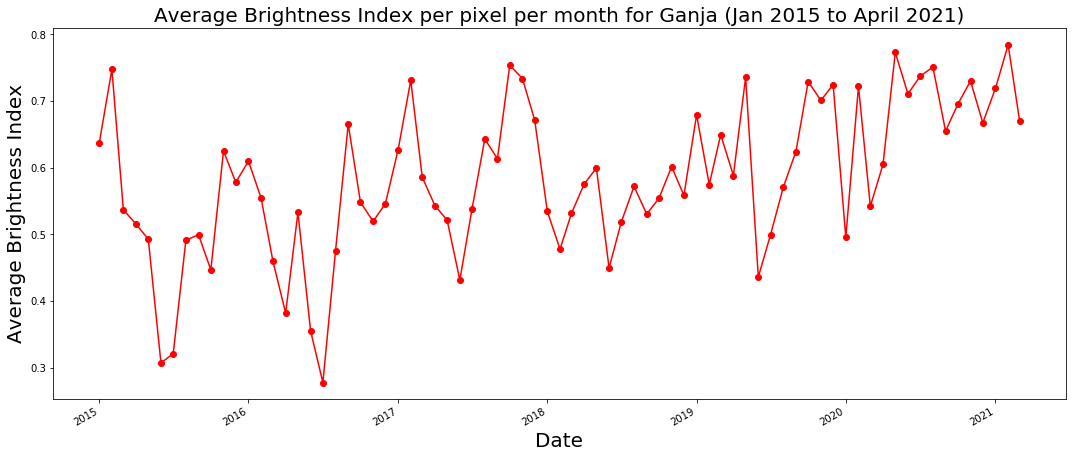

In [52]:
#ganja = br.ganja_brightness(date_from = '2015-01-01', date_to = '2021-04-01', 
                           # ganja_lat = 40.6879, ganja_lon = 46.3723, buffer_distance = 50000)
#ganja.to_csv("data/ganja_brightness.csv")
ganja = pd.read_csv("data/ganja_brightness.csv")
first_day_of_month= pd.date_range('2015-01-01', '2021-04-01', freq='1M') - pd.offsets.MonthBegin(1)
df_date_first_days = pd.DataFrame(data = first_day_of_month, columns = ["first_day_dates"])
f = df_date_first_days["first_day_dates"].dt.date
fig, ax = plt.subplots(figsize=(15,7))
plt.plot_date(f, ganja["ganja_brightness"], linestyle = 'solid', color = 'r')
ax.set_ylabel('Average Brightness Index',fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_title('Average Brightness Index per pixel per month for Ganja (Jan 2015 to April 2021)',fontsize=20)
plt.tight_layout()
plt.gcf().autofmt_xdate()

### 3.2. Unit Test on Brightness Index function <a class="anchor" id="unittest"></a>

A **Unit Test** is a small test that checks at a time whether a single component in an application/function/etc. works in the expected way. There are many test runners in Python, the one that is built into standard Python library is called **unittest**, which you need to simply import, for it to run the test. To write and execute your test in unittest, there are some requirements:
* ```Python
import unittest
```
* Put your tests into classes as methods, for that one needs to create a subclass, that inherits from unittest TestCase class
* Add *self* as the first and only argument for test functions
* Instead of built-in assert statement, use self.assertEqual(), self.assertIs(), self.assertTrue(), self.assertIn(),etc. methods of the TestCase Class. 
* To run the test in shell, there are different command line entries; e.g., <br>

This one executes your test file:
```Python
python <'the name of the test file goes here'> 
```

This one executes your test file and -v (verbose) option lists the names of the functions and the result of each:
```Python
python -m unittest -v <'the name of the test file goes here'>
```  

In [ ]:
# ! python -m unittest -v test_brightness